### Resource

- [google drive](https://drive.google.com/drive/u/1/folders/1N15PTA1y0ou5YyPDUN-MdlTGPXq3Rxhc)
- [iowa liquor dataset](https://console.cloud.google.com/bigquery?authuser=1&invt=AbtrQg&project=solid-dominion-452916-p4&supportedpurview=project&ws=!1m5!1m4!4m3!1sbigquery-public-data!2siowa_liquor_sales!3ssales)
- [iowa population](https://data.iowa.gov/Community-Demographics/County-Population-in-Iowa-by-Year/qtnr-zsrc/about_data)
- [iowa income](https://data.iowa.gov/Economic-Statistics/Annual-Personal-Income-for-State-of-Iowa-by-County/st2k-2ti2/about_data)

### Packages

In [42]:
import pandas_gbq
from google.oauth2 import service_account
import pandas as pd
import plotnine as p9
from sodapy import Socrata

### Load Data

In [3]:
SERVICE_ACCOUNT_FILE = 'secret/service_account_key.json'
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE)

sql = """
SELECT 
    date,
    store_name,
    city,
    county,
    item_description,
    state_bottle_cost,
    state_bottle_retail,
    bottles_sold,
    sale_dollars,
    volume_sold_liters
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date >= '2024-01-01' AND date < '2025-01-01'
"""

df = pandas_gbq.read_gbq(sql, credentials=credentials)

Downloading: 100%|██████████|


In [4]:
df['profit'] = (
    (df['state_bottle_retail'] - df['state_bottle_cost']) * df['bottles_sold']
)
df.head()

,date,store_name,city,county,item_description,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,profit
0,2024-05-06,RIVERSIDE #4 / BETTENDORF,BETTENDORF,SCOTT,PARROT BAY VARIETY PACK MINI,4.80,7.20,1,7.20,0.05,2.4
1,2024-11-03,TEQUILA'S LIQUOR STORE,DES MOINES,POLK,NEW AMSTERDAM PINK WHITNEY BUCKET MINI,55.98,83.97,1,83.97,0.05,27.99
2,2024-10-23,HY-VEE FOOD STORE / CHEROKEE,CHEROKEE,CHEROKEE,99 TOASTED FLAVORITES MINI,52.32,78.48,1,78.48,0.05,26.16
3,2024-07-01,FAREWAY STORES #963 / CEDAR RAPIDS,CEDAR RAPIDS,LINN,CROWN ROYAL REGAL APPLE MINI,5.91,8.87,1,8.87,0.05,2.96
4,2024-07-06,CASEY'S GENERAL STORE #3035 / ATLANT,ATLANTIC,CASS,CROWN ROYAL REGAL APPLE MINI,5.91,8.87,1,8.87,0.05,2.96


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2590975 entries, 0 to 2590974
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   date                 dbdate 
 1   store_name           object 
 2   city                 object 
 3   county               object 
 4   item_description     object 
 5   state_bottle_cost    float64
 6   state_bottle_retail  float64
 7   bottles_sold         Int64  
 8   sale_dollars         float64
 9   volume_sold_liters   float64
 10  profit               Float64
dtypes: Float64(1), Int64(1), dbdate(1), float64(4), object(4)
memory usage: 222.4+ MB


In [6]:
print("The earliest date:", df['date'].min())
print("The latest date:", df['date'].max())

The earliest date: 2024-01-01
The latest date: 2024-12-31


In [8]:
print("Store:", df['store_name'].nunique())
print("City:", df['city'].nunique())
print("County:", df['county'].nunique())

Store: 2151
City: 471
County: 99


In [24]:
df_store = df.groupby(['store_name', 'city', 'county', 'date'])['sale_dollars'].sum().reset_index(name='total_sales')
df_store.head()

,store_name,city,county,date,total_sales
0,'DA BOOZE BARN / WEST BEND,WEST BEND,PALO ALTO,2024-01-04,1371.08
1,'DA BOOZE BARN / WEST BEND,WEST BEND,PALO ALTO,2024-01-10,3073.59
2,'DA BOOZE BARN / WEST BEND,WEST BEND,PALO ALTO,2024-01-17,3294.51
3,'DA BOOZE BARN / WEST BEND,WEST BEND,PALO ALTO,2024-01-24,2346.17
4,'DA BOOZE BARN / WEST BEND,WEST BEND,PALO ALTO,2024-01-31,3409.15


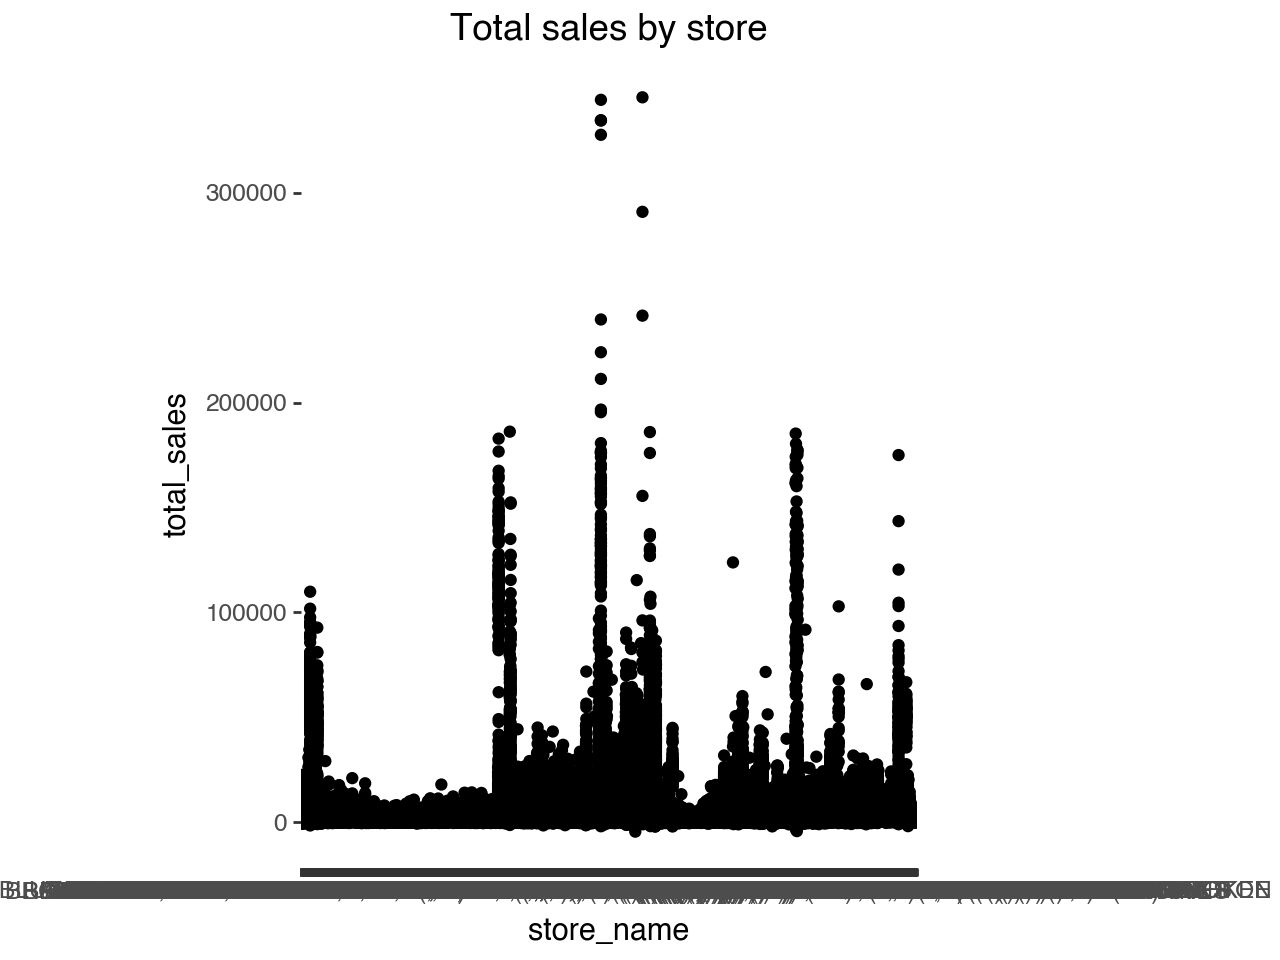

In [25]:
plot = (
    p9.ggplot(df_store, p9.aes(x='store_name', y='total_sales')) +
    p9.geom_point() +
    p9.labs(title='Total sales by store')
)
plot

In [28]:
df_city = df.groupby(['city'])['sale_dollars'].sum().reset_index(name='total_sales')
df_city.head()

,city,total_sales
0,ACKLEY,98681.96
1,ADAIR,93979.20
2,ADEL,877257.26
3,AFTON,72310.34
4,AINSWORTH,53394.64


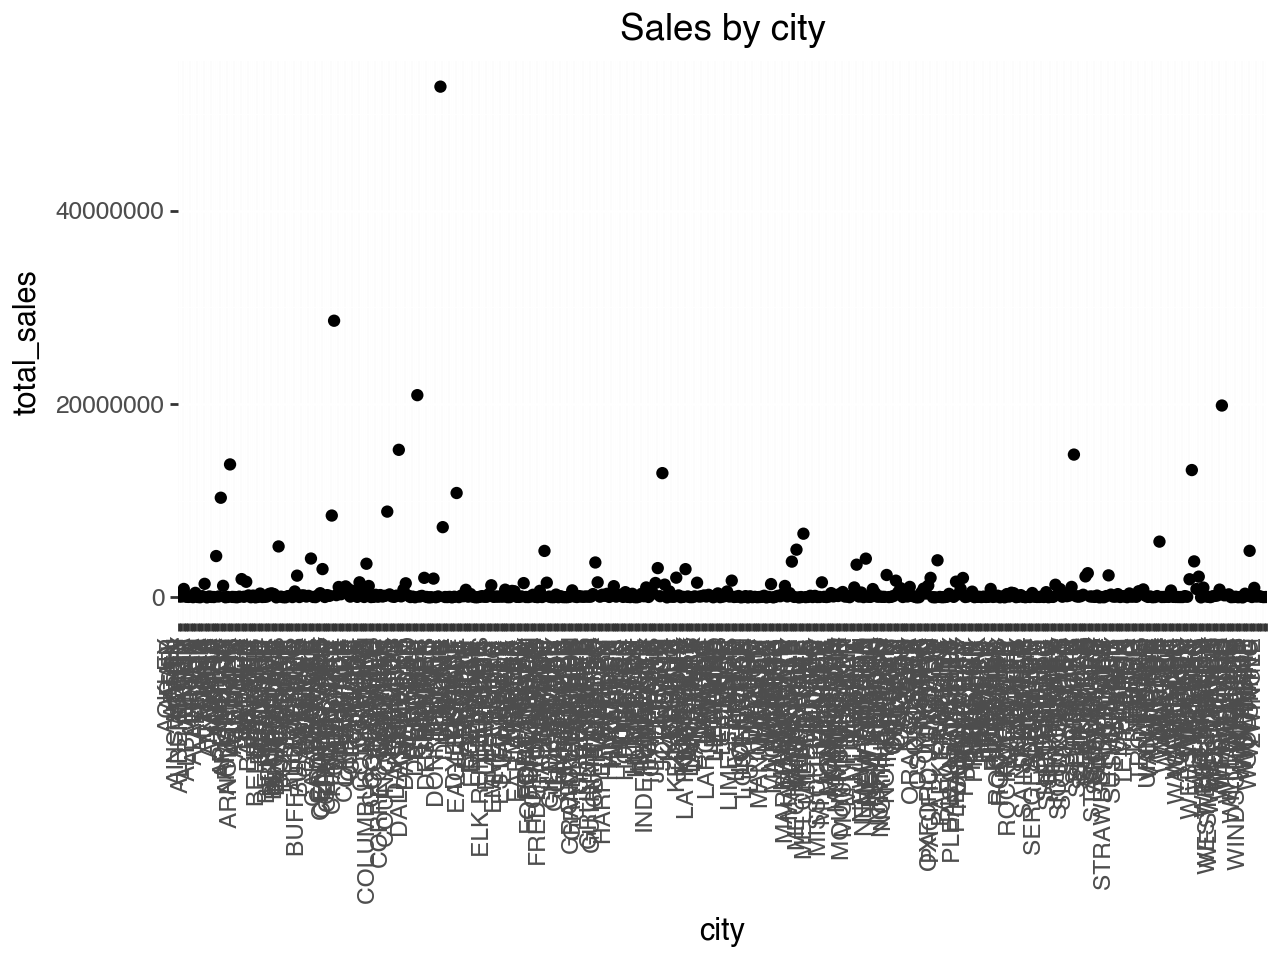

In [30]:
plot2 = (
    p9.ggplot(df_city, p9.aes(x='city', y='total_sales')) +
    p9.geom_point() +
    p9.labs(title='Sales by city') +
    p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1))
)
plot2

In [29]:
df_county = df.groupby(['county']).agg(
    revenue=('sale_dollars', 'sum'),
    profit=('profit', 'sum'),
).reset_index()
df_county['county'] = df_county['county'].str.lower()
df_county.head()

,county,revenue,profit
0,adair,619205.10,206548.04
1,adams,313394.31,104545.9
2,allamakee,1144949.95,382071.19
3,appanoose,1191277.99,397272.15
4,audubon,268753.09,89599.5


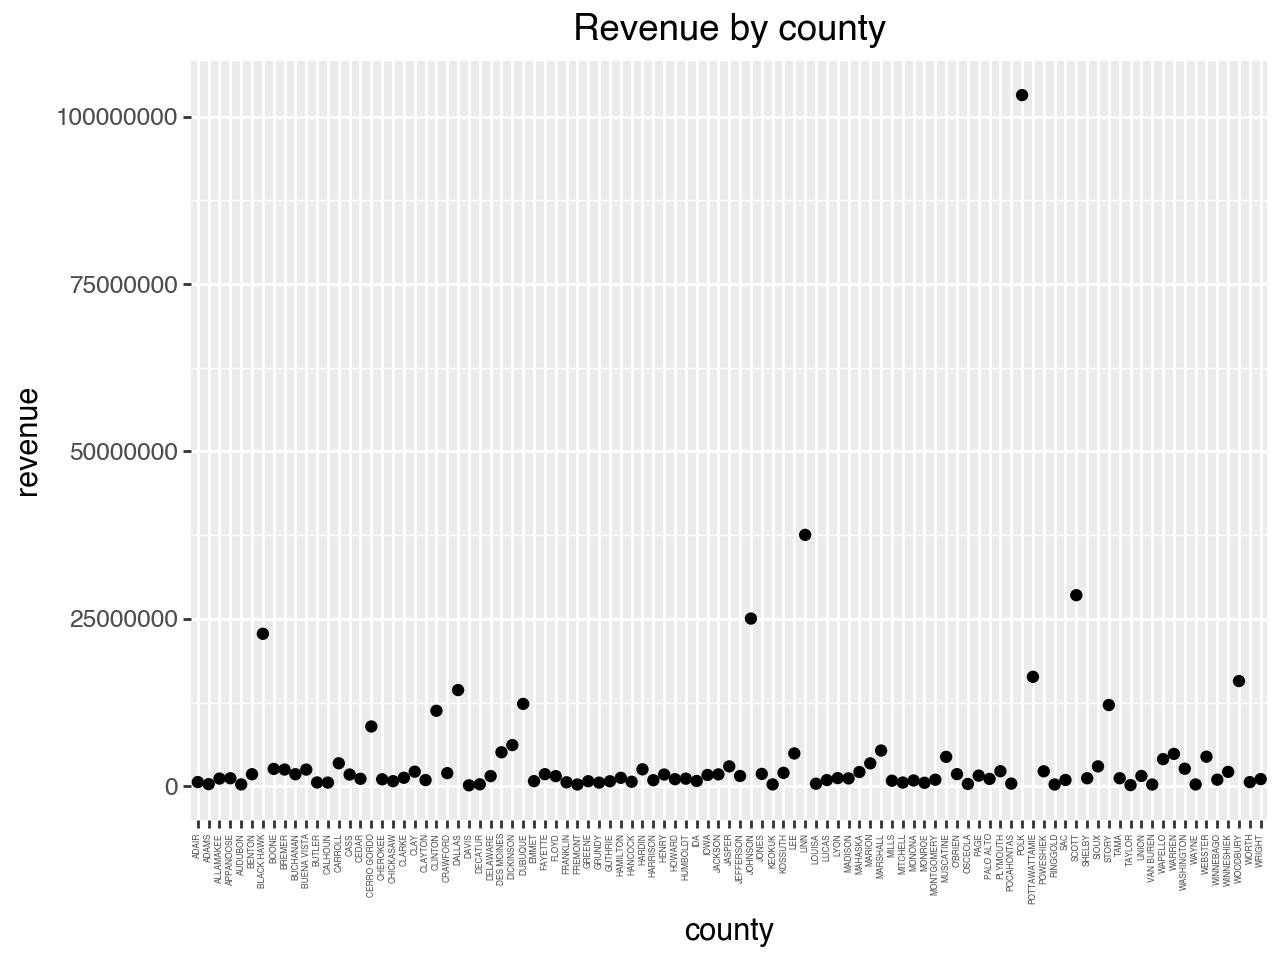

In [15]:
plot3 = (
    p9.ggplot(df_county, p9.aes(x='county', y='revenue')) +
    p9.geom_point() +
    p9.labs(title='Revenue by county') +
    p9.theme(axis_text_x=p9.element_text(rotation=90, size=3))
)
plot3

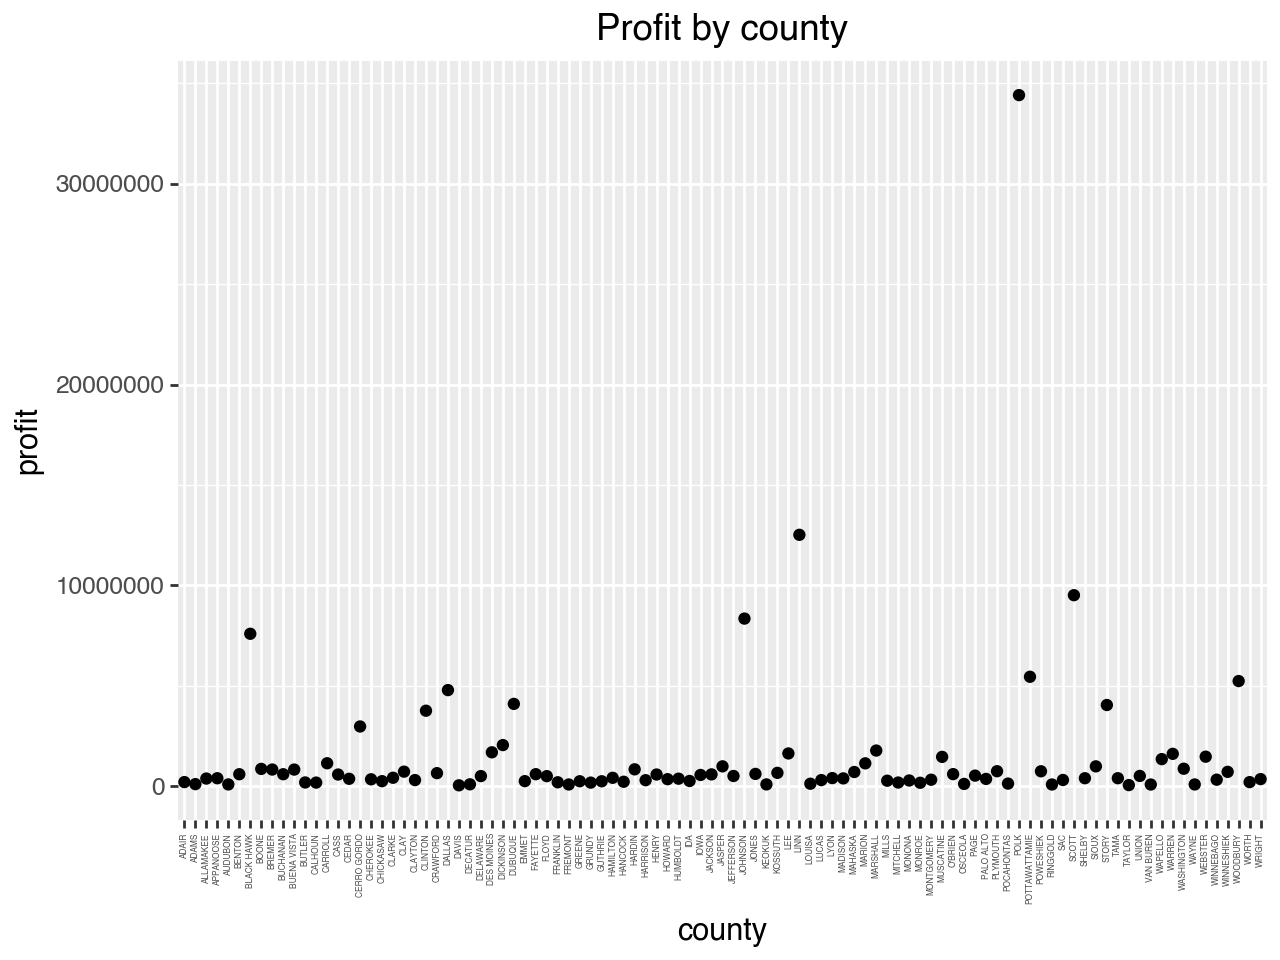

In [16]:
plot4 = (
    p9.ggplot(df_county, p9.aes(x='county', y='profit')) +
    p9.geom_point() +
    p9.labs(title='Profit by county') +
    p9.theme(axis_text_x=p9.element_text(rotation=90, size=3))
)
plot4

In [31]:
df_pop = pd.read_csv('data/iowa_population.csv')
df_pop.columns = df_pop.columns.str.lower()
df_pop['year'] = df_pop['year'].str[-4:]
df_pop['county'] = df_pop['county'].str[:-7]
df_pop['county'] = df_pop['county'].str.lower()
df_pop = df_pop[['county', 'year', 'population']]
df_pop = df_pop[df_pop['year']=='2023']
df_pop.head()

,county,year,population
35,poweshiek,2023,18453
134,jefferson,2023,15440
158,chickasaw,2023,11658
242,mitchell,2023,10518
245,wright,2023,12656


In [23]:
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99 entries, 35 to 3351
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   county      99 non-null     object
 1   year        99 non-null     object
 2   population  99 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 3.1+ KB


In [19]:
df_pop['county'].nunique()

99

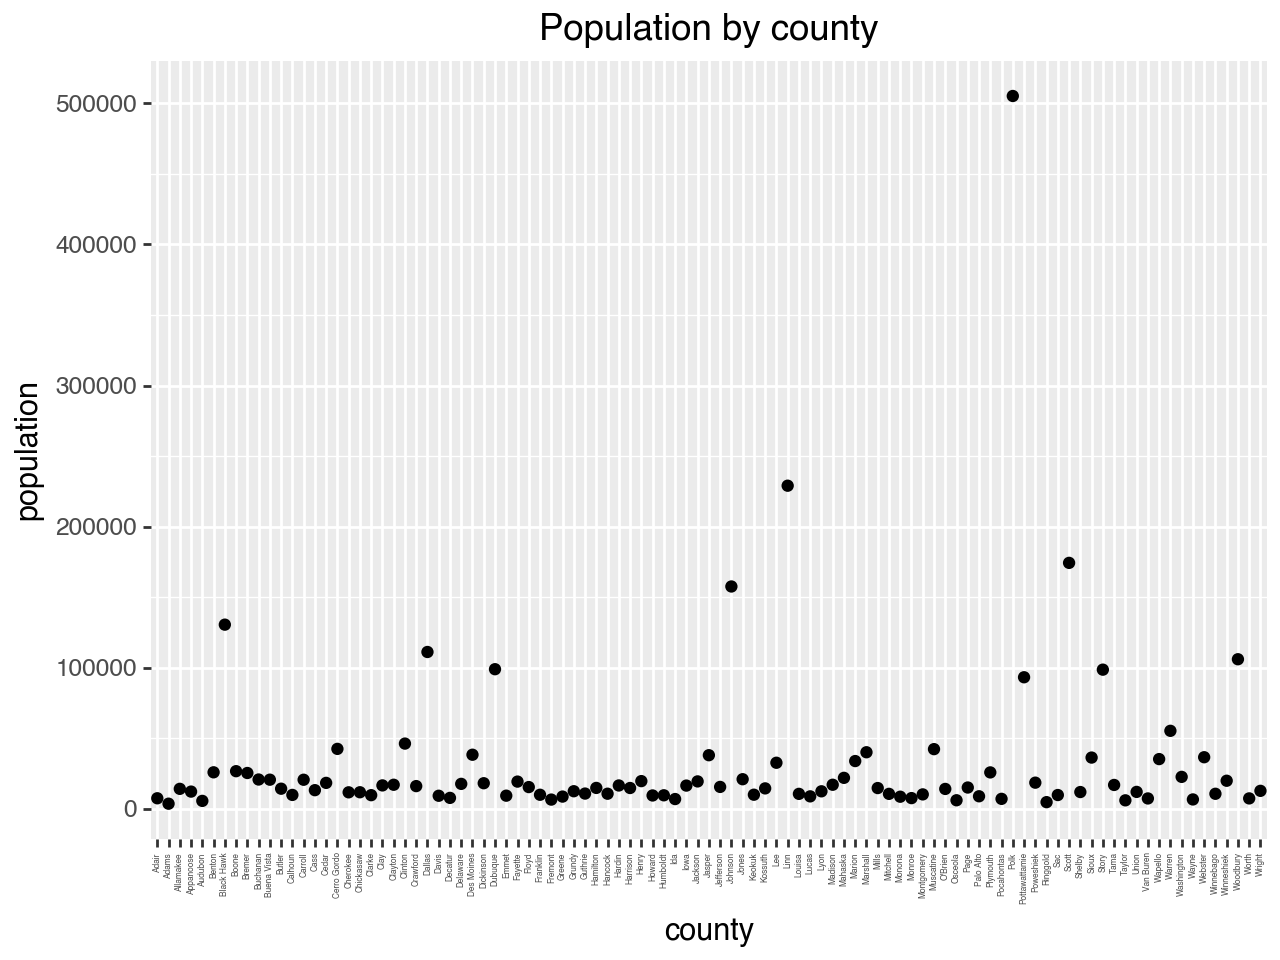

In [24]:
plot5 = (
    p9.ggplot(df_pop, p9.aes(x='county', y='population')) +
    p9.geom_point() +
    p9.labs(title='Population by county') +
    p9.theme(axis_text_x=p9.element_text(rotation=90, size=3))
)
plot5

In [25]:
plot4.save('profit_by_county.png', dpi=300, width=10, height=5)
plot5.save('population_by_county.png', dpi=300, width=10, height=5)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 5 in image.
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: profit_by_county.png
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 5 in image.
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: population_by_county.png


In [32]:
df_pop_profit = pd.merge(df_pop, df_county, on='county', how='inner')
df_pop_profit.head()

,county,year,population,revenue,profit
0,poweshiek,2023,18453,2228256.70,743397.02
1,jefferson,2023,15440,1528225.79,509646.76
2,chickasaw,2023,11658,753329.44,251419.36
3,mitchell,2023,10518,551215.86,184028.73
4,wright,2023,12656,1063306.24,354556.28


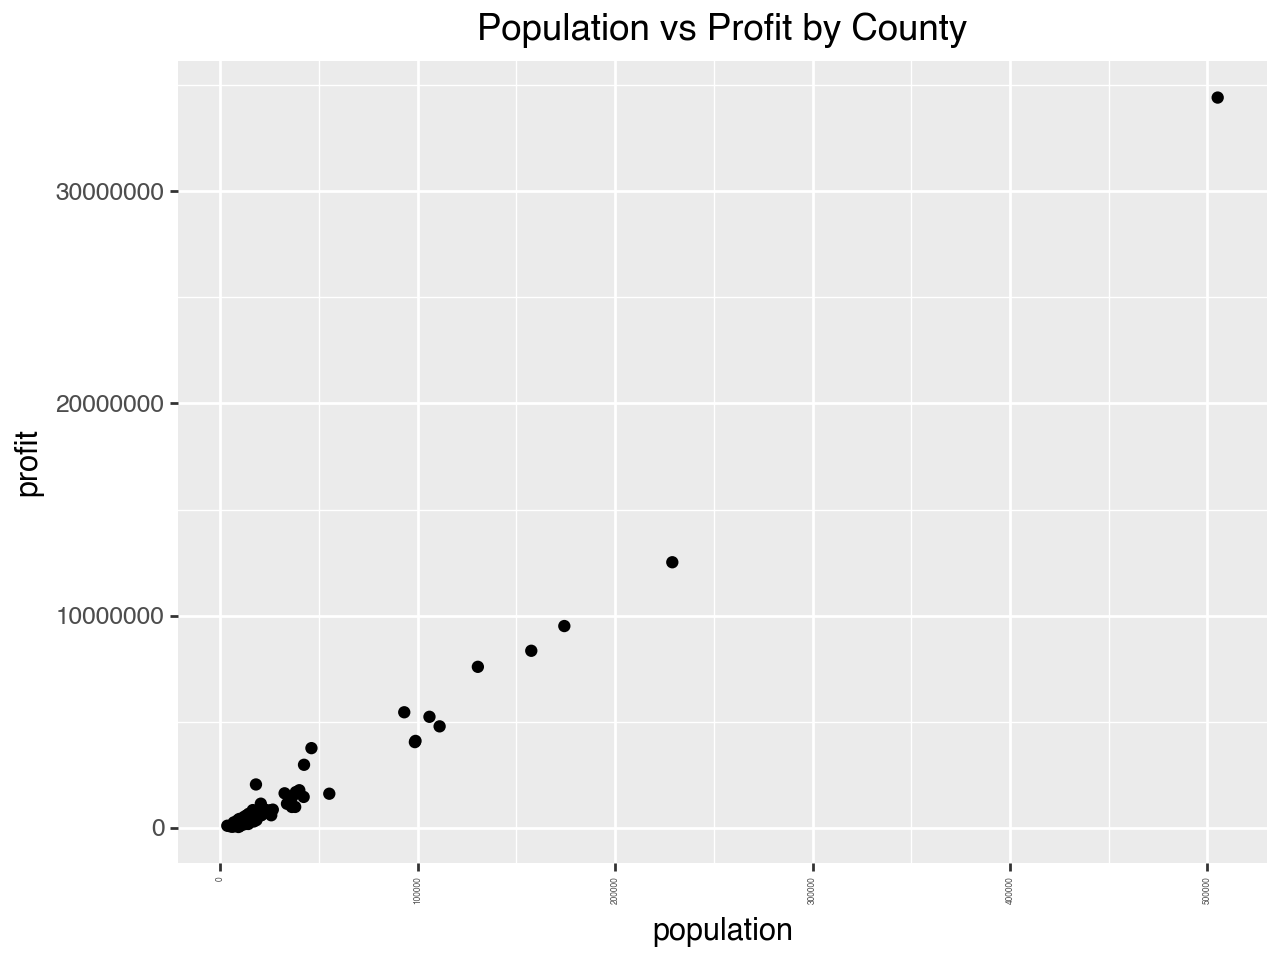

In [33]:
plot6 = (
    p9.ggplot(df_pop_profit, p9.aes(x='population', y='profit')) +
    p9.geom_point() +
    p9.labs(title='Population vs Profit by County') +
    p9.theme(axis_text_x=p9.element_text(rotation=90, size=3))
)
plot6

In [78]:
client = Socrata("data.iowa.gov", None)
df_list = []
offset = 0

while True:
    results = client.get("st2k-2ti2",
                         limit = 1000,
                         offset = offset)
    offset = offset + 1000
    df_list.extend(results)

    if len(results) < 1000:
        break

df_income = pd.DataFrame.from_records(df_list)
df_income.head()

,row_id,geography_id,name,variable_code,variable,value,variable_unit,date,location,:@computed_region_hhz5_dst4,:@computed_region_y683_txed
0,19001_1997_CAINC1-1_annual,19001,Adair,CAINC1-1,Personal income,176229,Thousands of dollars,1997-12-31T00:00:00.000,"{'type': 'Point', 'coordinates': [-94.478164, ...",4,72
1,19001_1997_CAINC1-3_annual,19001,Adair,CAINC1-3,Per capita personal income,21207,Dollars,1997-12-31T00:00:00.000,"{'type': 'Point', 'coordinates': [-94.478164, ...",4,72
2,19001_1998_CAINC1-1_annual,19001,Adair,CAINC1-1,Personal income,183755,Thousands of dollars,1998-12-31T00:00:00.000,"{'type': 'Point', 'coordinates': [-94.478164, ...",4,72
3,19001_1998_CAINC1-3_annual,19001,Adair,CAINC1-3,Per capita personal income,22126,Dollars,1998-12-31T00:00:00.000,"{'type': 'Point', 'coordinates': [-94.478164, ...",4,72
4,19001_1999_CAINC1-1_annual,19001,Adair,CAINC1-1,Personal income,188850,Thousands of dollars,1999-12-31T00:00:00.000,"{'type': 'Point', 'coordinates': [-94.478164, ...",4,72


In [79]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5148 entries, 0 to 5147
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   row_id                       5148 non-null   object
 1   geography_id                 5148 non-null   object
 2   name                         5148 non-null   object
 3   variable_code                5148 non-null   object
 4   variable                     5148 non-null   object
 5   value                        5148 non-null   object
 6   variable_unit                5148 non-null   object
 7   date                         5148 non-null   object
 8   location                     5148 non-null   object
 9   :@computed_region_hhz5_dst4  5148 non-null   object
 10  :@computed_region_y683_txed  5148 non-null   object
dtypes: object(11)
memory usage: 442.5+ KB


In [80]:
df_income['date'] = df_income['date'].str[:4]
df_income = df_income[
    (df_income['date']=='2022') & 
    (df_income['variable']=='Per capita personal income')
    ]
df_income.rename(columns={
    'name': 'county',
    'date': 'year',
    'value': 'annual_income',
}, inplace=True)
df_income['county'] = df_income['county'].str.lower()
df_income = df_income[['county', 'year', 'annual_income']]
df_income['annual_income'] = pd.to_numeric(df_income['annual_income'], errors='coerce')
df_income.head()

,county,year,annual_income
51,adair,2022,67668
103,adams,2022,67657
155,allamakee,2022,55015
207,appanoose,2022,47779
259,audubon,2022,69105


In [81]:
df_income.shape[0]

99

In [71]:
df_income['county'].nunique()

99

In [82]:
df_pop_profit_income = pd.merge(df_pop_profit, df_income, on='county', how='inner')
df_pop_profit_income.head()

,county,year_x,population,revenue,profit,year_y,annual_income
0,poweshiek,2023,18453,2228256.70,743397.02,2022,56228
1,jefferson,2023,15440,1528225.79,509646.76,2022,54979
2,chickasaw,2023,11658,753329.44,251419.36,2022,89185
3,mitchell,2023,10518,551215.86,184028.73,2022,96075
4,wright,2023,12656,1063306.24,354556.28,2022,70420


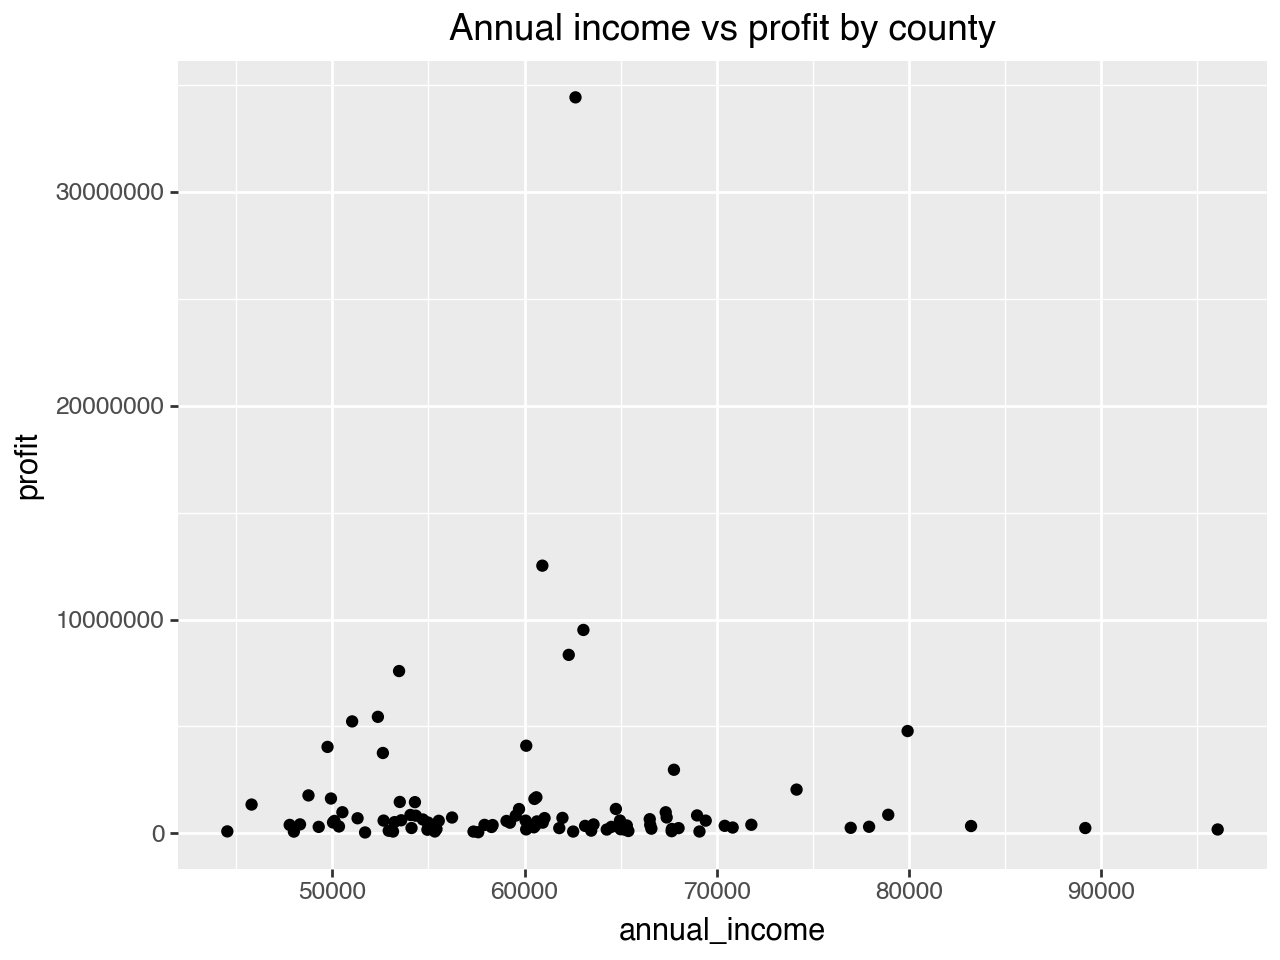

In [85]:
plot7 = (
    p9.ggplot(df_pop_profit_income) +
    p9.aes(x='annual_income', y='profit') +
    p9.geom_point() +
    p9.labs(title='Annual income vs profit by county')
)
plot7

In [87]:
df_pop_profit_income[df_pop_profit_income['profit'] > 10000000]

,county,year_x,population,revenue,profit,year_y,annual_income
49,polk,2023,505255,1.032223e+08,34411573.16,2022,62653
92,linn,2023,228972,3.753996e+07,12518203.1,2022,60928
